# An interpretable prediction system for the Site Of Origin (SOO) of Outflow Tract Ventricular Arrhythmias (OTVAs)

## 0. Starting point

See first the [README](README.md) for a general introduction to the project. We will start analyzing what we have as input, and how will we approach the tasks given our restrictions (dataset, interpretability, fast inference).

### 0.1. About the dataset

We were provided with a dataset with anonymous data from Teknon Medical Center, Barcelona, Spain. As explained in the [release](https://github.com/uripont/arrhythmia-origin-predictor/releases/download/dataset/dataset_arrhythmias.zip), the dataset contains electrocardiogram (ECG) recordings and demographic information from patients with Outflow Tract Ventricular Arrhythmias (OTVAs). Each case includes several 12-lead ECG signal segment (of 2.5 seconds), patient demographic data (age, sex, height, weight,...), and clinician-validated labels indicating the arrhythmia's Site of Origin (SOO). The SOO labels include Left Ventricular Outflow Tract (LVOT), Right Ventricular Outflow Tract (RVOT), and for LVOT cases, further classification into Right Coronary Cusp (RCC) or aortomitral commissure origins among others. 

The following code retrieves the dataset from the release and unzips it into `dataset/` folder, from which we will later load the data and perform the preprocessing. This allows 1:1 reproducibility of the results by performing this notebook's logic on the same input data.


In [1]:
# Standard library packages:
import os
import urllib.request
import zipfile
import shutil
import pickle

# Third-party packages:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#TODO: add missing here and on requirements.txt

 
# If running this notebook produces import errors, please install missing packages:
# pip install -r requirements.txt
# 
# Consider using a virtual environment:
# python -m venv venv
# source venv/bin/activate  # On Windows: venv\Scripts\activate

In [2]:
# URL of the dataset zip file
dataset_url = "https://github.com/uripont/arrhythmia-origin-predictor/releases/download/dataset/dataset_arrhythmias.zip"

In [3]:
# Local paths
zip_path = "dataset_arrhythmias.zip"
extract_dir = "dataset"

# Create dataset directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Download the zip file
if not os.path.exists(zip_path):
    print(f"Downloading dataset from {dataset_url}...")
    urllib.request.urlretrieve(dataset_url, zip_path)
    print(f"Download complete. Saved to {zip_path}")
else:
    print(f"Dataset zip file already exists at {zip_path}")

# Extract the contents only if the directory is empty or doesn't exist
if not os.path.exists(extract_dir) or not os.listdir(extract_dir):
    print(f"Extracting files to {extract_dir}/")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Dataset is ready in the '{extract_dir}' directory.")
else:
    print(f"Extraction directory already exists: {extract_dir}/")

Dataset zip file already exists at dataset_arrhythmias.zip
Extraction directory already exists: dataset/


In [4]:
# Print the contents of the extracted directory, filtering out hidden files/folders
extracted_files = [f for f in os.listdir(extract_dir) 
                  if not f.startswith('.') and not f.startswith('__')]
print("Extracted files:")
for file in extracted_files:
    print(f"- {file}")

Extracted files:
- label2.xlsx
- labels_FontiersUnsupervised.xlsx
- all_points_may_2024.pkl


### 0.2. Patient cases

The dataset structure consists of patient records where each patient has demographic data (age, sex, height, medical conditions,...) stored in the main `.pkl` file, and multiple ECG recordings per patient stored in the 'Structures' column, corresponding to distinct measurement points with different lead positionings.

Our goal is to have a normalized table-like structure of what we refer to as a "patient case". Each patient case consists of a single full ECG paired with the demographic data of that patient. Each patient is identified by a 'PXXX' identifier, so to create our cases we will combine each patient's demographic data with their individual ECG recordings, effectively duplicating demographic information across all ECG segments belonging to that patient.

## 1. Our approach

//TODO: explain system of models, Model A for dimensionality reduction of ECGs, merge this with the encoded demographic data, and then do a filtering step (remove either the SOO or the sub-region) so that we are left with a single target variable, and then train Model B and Model C for classification of the SOO and sub-regions respectively.

//TODO: explain how we want to give basically all variability of the dataset to the classification model, but first preprocessing it to represent this same data in a much smaller dimensionality that corresponds to learned, interpretable features.

//TODO: explain how we do transformations of the loaded dataset (dataframe) to clean it/reduce it, inspired by RDD's

//TODO: explain what families and kinds of models we are considering for both the dimensionality reduction and the classification, as well as how we plan to use multiple model training and evaluation to find the best performing models for each task.


## 2. Demographic data preprocessing

We start by loading the demographic data from the dataset, which is spread out between all 3 different extracted files. We want to clean it up and have a clear set of demographic features per patient.

We start by displaying all data from the `.pkl` file, to see the broader structure of the nested dictionaries that this file contains:

In [5]:
data = pickle.load(open(os.path.join(extract_dir, 'all_points_may_2024.pkl'), 'rb'))
data = pd.DataFrame(data).T

display(data.head())

,Sex,HTA,Age,PVC_transition,SOO_chamber,Height,Weight,BMI,DM,DLP,Smoker,COPD,Sleep_apnea,CLINICAL_SCORE,SOO,OTorigin,Structures
P186,[Female],[nan],[61.0],[V1],[Right ventricle],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[Unión mitroaórtica],[0.0],{'2-LV': {'P36': {'I': [-0.075 -0.075 -0.072 ....
P245,[Female],[No],[52.0],[V3],[RVOT],[169.0],[68.0],[nan],[No],[No],[No],[No],[No],[1.0],[Pared libre anterior],[1.0],{'2-RV': {'P157': {'I': [ 0. 0. 0. ...
P292,[Female],[No],[69.0],[V3],[LVOT],[156.0],[70.0],[nan],[No],[Yes],[No],[No],[No],[1.0],[RCC],[1.0],{'2-AO': {'P55': {'I': [-0.063 -0.051 -0.03 ....
P205,[Female],[No],[66.0],[V4],[Right ventricle],[176.0],[63.0],[20.33832644628099],[No],[No],[No],[No],[No],[1.0],[M. papilar posteromedial],[0.0],{'2-1-Rp-LV': {'P320': {'I': [-0.297 -0.288 -0...
P066,[Female],[Yes],[46.0],[V3],[RVOT],[160.0],[79.0],[30.85937499999999],[No],[No],[No],[No],[No],[1.0],[RVOT septal],[1.0],{'1-PA': {'P13': {'I': [-0.006 -0.003 -0.003 ....


In [6]:
# Print initial .pkl dataframe shape
print(f"Initial DataFrame shape: {data.shape}")

Initial DataFrame shape: (190, 17)


We can see that the data is structured in a way that each row corresponds to a patient, and each column corresponds to a demographic feature, except for the `Structures` column, which contains nested dictionaries with several different ECGs for each individual patient.

In [7]:
data.drop(columns=['Structures'], inplace=True)
display(data.head())

,Sex,HTA,Age,PVC_transition,SOO_chamber,Height,Weight,BMI,DM,DLP,Smoker,COPD,Sleep_apnea,CLINICAL_SCORE,SOO,OTorigin
P186,[Female],[nan],[61.0],[V1],[Right ventricle],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[nan],[Unión mitroaórtica],[0.0]
P245,[Female],[No],[52.0],[V3],[RVOT],[169.0],[68.0],[nan],[No],[No],[No],[No],[No],[1.0],[Pared libre anterior],[1.0]
P292,[Female],[No],[69.0],[V3],[LVOT],[156.0],[70.0],[nan],[No],[Yes],[No],[No],[No],[1.0],[RCC],[1.0]
P205,[Female],[No],[66.0],[V4],[Right ventricle],[176.0],[63.0],[20.33832644628099],[No],[No],[No],[No],[No],[1.0],[M. papilar posteromedial],[0.0]
P066,[Female],[Yes],[46.0],[V3],[RVOT],[160.0],[79.0],[30.85937499999999],[No],[No],[No],[No],[No],[1.0],[RVOT septal],[1.0]


### 2.1. Flattening and binarizing the demographic data

Having removed these for now, we'll focus on the other 16 columns (demographic data), which we will preprocess now. We start by flattening out the current lists of values in indivudal cells, as can be seen from previous cell outputs, so that they are just single values:

In [8]:
def remove_lists(x):
    if isinstance(x, list):
        if len(x) == 1:
            return x[0]  # Return single value
        elif len(x) == 0:
            return np.nan  # Empty list returns NaN
        else:
            return ', '.join(str(i) for i in x)  # Multiple elements return string
    return x  # If not a list, return as is

data = data.transform(lambda s: s.map(remove_lists))
display(data)

,Sex,HTA,Age,PVC_transition,SOO_chamber,Height,Weight,BMI,DM,DLP,Smoker,COPD,Sleep_apnea,CLINICAL_SCORE,SOO,OTorigin
P186,Female,NaN,61.0,V1,Right ventricle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unión mitroaórtica,0.0
P245,Female,No,52.0,V3,RVOT,169.0,68.0,NaN,No,No,No,No,No,1.0,Pared libre anterior,1.0
P292,Female,No,69.0,V3,LVOT,156.0,70.0,NaN,No,Yes,No,No,No,1.0,RCC,1.0
P205,Female,No,66.0,V4,Right ventricle,176.0,63.0,20.338326,No,No,No,No,No,1.0,M. papilar posteromedial,0.0
P066,Female,Yes,46.0,V3,RVOT,160.0,79.0,30.859375,No,No,No,No,No,1.0,RVOT septal,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P018,Male,Yes,61.0,V1,Right ventricle,188.0,90.0,25.464011,No,No,No,No,No,3.0,LV summit,0.0
P124,Male,Yes,52.0,V3,LVOT,182.0,83.0,25.057360,No,No,No,No,No,3.0,Seno de Valsalva dcho.,1.0
P171,Male,No,77.0,V6,Right ventricle,NaN,NaN,NaN,No,No,No,No,No,2.0,LV inferobasal,0.0
P219,Male,Yes,88.0,V1,Mitral annulus,166.0,90.0,NaN,Yes,Yes,No,No,No,3.0,Anillo mitral anterolateral,0.0


In [9]:
def convert_to_binary(value, true_value, false_value):
    if pd.isna(value):
        return None
    elif value == true_value:
        return 1
    elif value == false_value:
        return 0
    return None

def apply_binary_conversion(df, columns_dict):
    print("Converting categorical columns to binary:")
    for column, (true_value, false_value) in columns_dict.items():
        initial_count = df[column].notna().sum()
        
        df[column] = df[column].apply(lambda x: convert_to_binary(x, true_value, false_value))

        null_count = df[column].isna().sum()     
        print(f"- {column}: {initial_count - null_count} converted, "
              f"{null_count} null")
    
    return df

binary_columns = {
    'Sex': ('Female', 'Male'),
    'HTA': ('Yes', 'No'),
    'DM': ('Yes', 'No'),
    'DLP': ('Yes', 'No'),
    'Smoker': ('Yes', 'No'),
    'COPD': ('Yes', 'No'),
    'Sleep_apnea': ('Yes', 'No')
}

data = apply_binary_conversion(data, binary_columns)
display(data)

Converting categorical columns to binary:
- Sex: 184 converted, 3 null
- HTA: 176 converted, 7 null
- DM: 174 converted, 8 null
- DLP: 176 converted, 7 null
- Smoker: 172 converted, 9 null
- COPD: 174 converted, 8 null
- Sleep_apnea: 172 converted, 9 null


,Sex,HTA,Age,PVC_transition,SOO_chamber,Height,Weight,BMI,DM,DLP,Smoker,COPD,Sleep_apnea,CLINICAL_SCORE,SOO,OTorigin
P186,1.0,NaN,61.0,V1,Right ventricle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unión mitroaórtica,0.0
P245,1.0,0.0,52.0,V3,RVOT,169.0,68.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,Pared libre anterior,1.0
P292,1.0,0.0,69.0,V3,LVOT,156.0,70.0,NaN,0.0,1.0,0.0,0.0,0.0,1.0,RCC,1.0
P205,1.0,0.0,66.0,V4,Right ventricle,176.0,63.0,20.338326,0.0,0.0,0.0,0.0,0.0,1.0,M. papilar posteromedial,0.0
P066,1.0,1.0,46.0,V3,RVOT,160.0,79.0,30.859375,0.0,0.0,0.0,0.0,0.0,1.0,RVOT septal,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P018,0.0,1.0,61.0,V1,Right ventricle,188.0,90.0,25.464011,0.0,0.0,0.0,0.0,0.0,3.0,LV summit,0.0
P124,0.0,1.0,52.0,V3,LVOT,182.0,83.0,25.057360,0.0,0.0,0.0,0.0,0.0,3.0,Seno de Valsalva dcho.,1.0
P171,0.0,0.0,77.0,V6,Right ventricle,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,2.0,LV inferobasal,0.0
P219,0.0,1.0,88.0,V1,Mitral annulus,166.0,90.0,NaN,1.0,1.0,0.0,0.0,0.0,3.0,Anillo mitral anterolateral,0.0


### 2.2. Filliing missing height and weight with mean/median

We start now dealing with different missing values in the dataset. We start with weight, height and BMI. These columns might be important for the model to learn, yet having non-precise values in them might not be a big problem (having a "normal" height or weight is a better assumption than either having a NaN value or dropping the entire patient).

To assign this "normal" value, we will use either the mean or the median of the column, depending on the presence of outliers:



Height outliers (0 found):

Weight outliers (4 found):
P276    120.0
P175    114.0
P136    117.0
P137    122.0


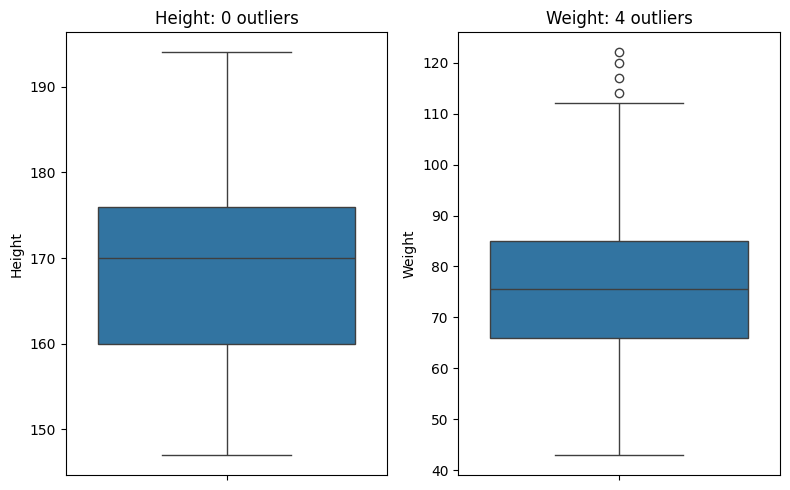

In [10]:
def analyze_outliers(df, columns):    
    # Single figure with subplots
    fig, axes = plt.subplots(1, len(columns), figsize=(4*len(columns), 5))
    if len(columns) == 1:
        axes = [axes]
        
    for i, col in enumerate(columns):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)]
        
        sns.boxplot(y=df[col], ax=axes[i])
        axes[i].set_title(f"{col}: {len(outliers)} outliers")
        
        # Print outlier details if any
        print(f"\n{col} outliers ({len(outliers)} found):")
        if len(outliers) > 0:
            print(outliers[col].to_string())
        
    plt.tight_layout()
    plt.show()


analyze_outliers(data, ['Height', 'Weight'])

As we don't have outliers in height, we will use the mean to calculate the missing values. On the contrary, as we have outliers in weight, we will use the median.

In [11]:
mean_height = data['Height'].mean()
median_weight= data['Weight'].median()
print('Mean height', mean_height)
print('Median weight', median_weight)

Mean height 169.21019108280254
Median weight 75.5


In [12]:
def fill_missing(df, column, value):
    missing_before = df[column].isna().sum()
    
    if missing_before == 0:
        print(f"No missing values in column '{column}' to fill")
        return df
        
    # Fill missing values
    df[column] = df[column].fillna(value)
    missing_after = df[column].isna().sum()
    filled_count = missing_before - missing_after
    
    print(f"Filled {filled_count} missing values in '{column}' with {value}")
    return df

data = fill_missing(data, 'Height', mean_height)
data = fill_missing(data, 'Weight', median_weight)


Filled 33 missing values in 'Height' with 169.21019108280254
Filled 34 missing values in 'Weight' with 75.5


### 2.3. Computing BMI for missing values

We see that there's a column for the Body Mass Index (BMI), which has some rows for which the values are NaN, but have the height and weight needed to calculate the BMI. We can calculate the BMI for these rows:

In [13]:
def compute_bmi(row):
    height = row['Height']
    weight = row['Weight']
    bmi = row['BMI']
    
    if (
        not pd.isna(height) and
        not pd.isna(weight) and
        pd.isna(bmi)
    ):
        height_m = height / 100  # Convert cm to m
        bmi = weight / (height_m ** 2)
        return round(bmi, 1)
    else:
        return bmi

def fill_missing_bmi_values(df):
    initial_missing = df['BMI'].isna().sum()

    df['BMI'] = df.apply(compute_bmi, axis=1)
    
    remaining_missing = df['BMI'].isna().sum()
    filled_count = initial_missing - remaining_missing
    
    print(f"BMI calculation statistics:")
    print(f"- {filled_count} missing BMI values were calculated")
    print(f"- {remaining_missing} BMI values remain missing")
    return df

data = fill_missing_bmi_values(data)
display(data)

BMI calculation statistics:
- 89 missing BMI values were calculated
- 0 BMI values remain missing


,Sex,HTA,Age,PVC_transition,SOO_chamber,Height,Weight,BMI,DM,DLP,Smoker,COPD,Sleep_apnea,CLINICAL_SCORE,SOO,OTorigin
P186,1.0,NaN,61.0,V1,Right ventricle,169.210191,75.5,26.400000,NaN,NaN,NaN,NaN,NaN,NaN,Unión mitroaórtica,0.0
P245,1.0,0.0,52.0,V3,RVOT,169.000000,68.0,23.800000,0.0,0.0,0.0,0.0,0.0,1.0,Pared libre anterior,1.0
P292,1.0,0.0,69.0,V3,LVOT,156.000000,70.0,28.800000,0.0,1.0,0.0,0.0,0.0,1.0,RCC,1.0
P205,1.0,0.0,66.0,V4,Right ventricle,176.000000,63.0,20.338326,0.0,0.0,0.0,0.0,0.0,1.0,M. papilar posteromedial,0.0
P066,1.0,1.0,46.0,V3,RVOT,160.000000,79.0,30.859375,0.0,0.0,0.0,0.0,0.0,1.0,RVOT septal,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P018,0.0,1.0,61.0,V1,Right ventricle,188.000000,90.0,25.464011,0.0,0.0,0.0,0.0,0.0,3.0,LV summit,0.0
P124,0.0,1.0,52.0,V3,LVOT,182.000000,83.0,25.057360,0.0,0.0,0.0,0.0,0.0,3.0,Seno de Valsalva dcho.,1.0
P171,0.0,0.0,77.0,V6,Right ventricle,169.210191,75.5,26.400000,0.0,0.0,0.0,0.0,0.0,2.0,LV inferobasal,0.0
P219,0.0,1.0,88.0,V1,Mitral annulus,166.000000,90.0,32.700000,1.0,1.0,0.0,0.0,0.0,3.0,Anillo mitral anterolateral,0.0


In [14]:
def check_missing_values(df, columns):
    if isinstance(columns, str):
        columns = [columns]
    
    for column in columns:
        missing_count = df[column].isna().sum()
        total_count = len(df)
        percent_missing = (missing_count / total_count) * 100
        
        print(f"- {column}: {missing_count} missing values ({percent_missing:.1f}%)")
    
    return

check_missing_values(data, ['Height', 'Weight', 'BMI'])

- Height: 0 missing values (0.0%)
- Weight: 0 missing values (0.0%)
- BMI: 0 missing values (0.0%)


### 2.4. Mapping outcomes from excel sheets

Now we'll focus on clearly determining what will be the target variable (labels) for both Model B and Model C, representing the SOO and sub-regions classification tasks respectively.

For Part 1 we will focus on the SOO classification, which is a binary classification task between LVOT and RVOT. We start inspecting the columns that might be related to the outcome, from the demographic data on the loaded `.pkl` file:

In [15]:
print(data['SOO_chamber'].value_counts())

SOO_chamber
RVOT                 76
Right ventricle      57
LVOT                 36
Coronary sinus        8
Tricuspid annulus     6
Mitral annulus        4
Left ventricle        3
Name: count, dtype: int64


As we can see, this data file has a problem: the values on the 'SOO_chamber' column are more in detail than we need. We have different values that we want to merge into just two: 'LVOT' and 'RVOT'.

On the other hand, regarding the 'SOO_region' column:

In [16]:
print(data['SOO'].value_counts())

SOO
RVOT anteroseptal                              13
LV summit                                       9
Intersenos dcho.-izdo.                          9
RVOT posterolateral                             9
Unión mitroaórtica                              8
                                               ..
VI inferoseptal basal                           1
rvot septo posterior                            1
Septo basal subaótico                           1
Seno coronario, ramo IV anterior (foco epi)     1
Left coronary cusp                              1
Name: count, Length: 93, dtype: int64


Here the problem is even worse, as we have 93 different values that we want to merge into just valid sub-regions of the LVOT and RVOT, that we later will filter out to just the ones that we want to use for Model C: 'RCC' and 'COMMISSURE'.

Fortunately, we have different `.xlsx` files that contain mappings of these values to the outcome labels we want to use. But we need to understand which columns do these sheets contain, and which sheet we will use for each of the two target variables.

In [17]:
labels_sheet1 = pd.read_excel(os.path.join(extract_dir, 'labels_FontiersUnsupervised.xlsx'))
labels_sheet1 = pd.DataFrame(labels_sheet1)
labels_sheet1.dropna(inplace=True)
display(labels_sheet1)

,SOO,SOO_Chamber,Automatic_SOO,Region_Simplified
0,LVOT cúspide derecha (cerca de la comisura),LVOT,RCC,RCC
1,RVOT supravalvular anterolateral,RVOT,RVOT Anterior,RVOTFREEWALL
2,RVOT anterior,RVOT,RVOT Anterior,RVOTFREEWALL
3,RVOT posteroseptal,RVOT,RVOT LateroSeptal,RVOTSEPTUM
4,LVOT intersenos de Valsalva dcho-izdo,LVOT,Intersinus,COMMISSURE
...,...,...,...,...
114,Postero Septal Subvalvular,RVOT,RVOT Septal,RVOTSEPTUM
115,RCC,LVOT,RCC,RCC
116,RVOT,RVOT,RVOT Lateral,RVOTFREEWALL
117,Summit,LVOT,LVOT Summit,SUMMIT


We can see how these two columns in the `.xlxs` have exactly the values that we want to use as labels/outcomes:

In [18]:
print("Distinct values in SOO_Chamber column:")
print(labels_sheet1['SOO_Chamber'].unique())
print("\nDistinct values in Region_Simplified column:")
print(labels_sheet1['Region_Simplified'].unique())

Distinct values in SOO_Chamber column:
['LVOT' 'RVOT']

Distinct values in Region_Simplified column:
['RCC' 'RVOTFREEWALL' 'RVOTSEPTUM' 'COMMISSURE' 'LVOTSUBVALVULAR' 'LCC'
 'SUMMIT']


Still, we have a second excel sheet, that we have moved to a separate `.xlxs` file:

In [19]:
labels_sheet2 = pd.read_excel(os.path.join(extract_dir, 'label2.xlsx'))
labels_sheet2 = pd.DataFrame(labels_sheet2)
labels_sheet2.dropna(inplace=True) 
display(labels_sheet2)

,OTorigin,SOO_chamber,SOO,Simplified
0,1.0,RVOT,RVOT lateral medio,RVOTFREEWALL
2,1.0,RVOT,RVOT anteroseptal subvalvular,RVOTSEPTUM
3,1.0,LVOT,LVOT cúspide derecha (cerca de la comisura),RCC
4,0.0,Tricuspid annulus,Anillo tricuspídeo lateral,RVOTSEPTUM
6,0.0,Right ventricle,VI laterobasal,LVOTSUBVALVULAR
...,...,...,...,...
290,1.0,LVOT,Intersinus,COMMISURE
291,1.0,LVOT,RCC,RCC
292,1.0,RVOT,RVOT,RVOTFREEWALL
293,1.0,LVOT,Summit,LVOTSUMMIT


In [20]:
print("Distinct values in SOO_chamber column:")
print(labels_sheet2['SOO_chamber'].unique())
print("\nDistinct values in Simplified column:")
print(labels_sheet2['Simplified'].unique())

Distinct values in SOO_chamber column:
['RVOT' 'LVOT' 'Tricuspid annulus' 'Right ventricle' 'Mitral annulus'
 'Coronary sinus' 'Left ventricle']

Distinct values in Simplified column:
['RVOTFREEWALL' 'RVOTSEPTUM' 'RCC' 'LVOTSUBVALVULAR' 'COMMISURE'
 'LVOTSUMMIT' 'LCC']


How does the information on these two files relate? 

We can clearly see that **sheet 1' 'SOO_Chamber' column is the right one for the SOO classification task**; since sheet 2's 'SOO_chamber' column contains more than just RVOT and LVOT.

In [21]:
subregions_sheet1 = set(labels_sheet1['Region_Simplified'].unique())
subregions_sheet2 = set(labels_sheet2['Simplified'].unique())
print(f"Subregions in sheet 1: {subregions_sheet1}")
print(f"Subregions in sheet 2: {subregions_sheet2}")

Subregions in sheet 1: {'SUMMIT', 'RVOTFREEWALL', 'RVOTSEPTUM', 'LVOTSUBVALVULAR', 'RCC', 'LCC', 'COMMISSURE'}
Subregions in sheet 2: {'COMMISURE', 'RVOTFREEWALL', 'RVOTSEPTUM', 'LVOTSUBVALVULAR', 'RCC', 'LCC', 'LVOTSUMMIT'}


On the other hand, we see that both sheets have a column that relates to the simplified sub-regions that we want to use for Model C, both containing exactly 7 unique different values, and these being the same except for 'SUMMIT' in sheet 1, which should match with 'LVOTSUMMIT' in sheet 2.

To determine which of the two sheets we will use as the source mapping for the sub-regions task, we'll check how many different values map to these 7 unique values in each of the two sheets:

In [22]:
rcc_count1 = (labels_sheet1['Region_Simplified'] == 'RCC').sum()
commissure_count1 = (labels_sheet1['Region_Simplified'] == 'COMMISSURE').sum()

rcc_count2 = (labels_sheet2['Simplified'] == 'RCC').sum()
commissure_count2 = (labels_sheet2['Simplified'] == 'COMMISURE').sum()

print("Sheet 1 mappings:")
print(f"- RCC: {rcc_count1} different values")
print(f"- COMMISSURE: {commissure_count1} different values")

print("\nSheet 2 mappings:")
print(f"- RCC: {rcc_count2} different values") 
print(f"- COMMISURE: {commissure_count2} different values")

total_mappings1 = len(labels_sheet1)
total_mappings2 = len(labels_sheet2)
print(f"\nTotal mappings in sheet 1: {total_mappings1}")
print(f"Total mappings in sheet 2: {total_mappings2}")

Sheet 1 mappings:
- RCC: 7 different values
- COMMISSURE: 12 different values

Sheet 2 mappings:
- RCC: 11 different values
- COMMISURE: 19 different values

Total mappings in sheet 1: 118
Total mappings in sheet 2: 266


From this data, we have decided that the **source of the sub-regions mapping will be sheet 2.**

We'll start matching data's 'SOO_chamber' column to the 'SOO' column in the `.xlxs` file, to create two columns in the dataframe, 'Outcome_B' and 'Outcome_C', containing the sheet's 'SOO_Chamber' and 'Region_Simplified' values respectively:

In [23]:
def standardize_outcome_b(df, sheet1, source_col, target_col):
    print("Starting standardization for Outcome_B using sheet1:")
    
    b_mapping = dict(zip(sheet1[target_col], sheet1['SOO_Chamber']))
    df['Outcome_B'] = df[source_col].map(b_mapping)
    
    # Handle unmapped values from first mapping pass
    unmapped_b = df['Outcome_B'].isna()
    unmapped_b_count = unmapped_b.sum()
    
    print(f"- {df['Outcome_B'].notna().sum()} values mapped ({df['Outcome_B'].notna().sum()/len(df)*100:.1f}%)")
    print(f"- {unmapped_b_count} values remain unmapped")
    
    if unmapped_b_count > 0:
        print(f"\nRemaining unmapped SOO values for Outcome_B ({unmapped_b_count}):")
        unmapped_soos = df.loc[df['Outcome_B'].isna(), 'SOO'].value_counts()
        for soo, count in unmapped_soos.items():
            print(f"  '{soo}': {count} occurrences")
    
    return df


data = standardize_outcome_b(data, labels_sheet1, 'SOO', 'SOO')

Starting standardization for Outcome_B using sheet1:
- 130 values mapped (68.4%)
- 60 values remain unmapped

Remaining unmapped SOO values for Outcome_B (60):
  'Unión mitroaórtica': 8 occurrences
  'Ostium del SC (crux cordis)': 3 occurrences
  'Fascicular posterior': 2 occurrences
  'Fascicular anterior': 2 occurrences
  'Intersinus': 1 occurrences
  'subvalvular aortico (summit)': 1 occurrences
  'Intersenos (LV)': 1 occurrences
  'rvot - pared libre': 1 occurrences
  'Septal posterior y anterior': 1 occurrences
  'LV inferoseptal medio': 1 occurrences
  'rvot sèeto posterior': 1 occurrences
  'fasciculo anterior LV': 1 occurrences
  'anillo lat': 1 occurrences
  'Fascículo anterior': 1 occurrences
  'Papilar anterolateral': 1 occurrences
  'Pared anterior-anteroseptal media (IAM)': 1 occurrences
  'rvot septal anterior': 1 occurrences
  'LV anteroseptal (foco intramiocárdico)': 1 occurrences
  'Musculo papilar infero-medial': 1 occurrences
  'Septo posterior, immediatamente subval

In [24]:
def standardize_outcome_c(df, sheet2, source_col, target_col):
    print("Starting standardization for Outcome_C using sheet2:")
    
    c_mapping = dict(zip(sheet2[target_col], sheet2['Simplified']))
    df['Outcome_C'] = df[source_col].map(c_mapping)
    
    unmapped_c = df['Outcome_C'].isna()
    unmapped_c_count = unmapped_c.sum()
    
    print(f"- {df['Outcome_C'].notna().sum()} values mapped ({df['Outcome_C'].notna().sum()/len(df)*100:.1f}%)")
    print(f"- {unmapped_c_count} values remain unmapped")
    
    if unmapped_c_count > 0:
        print(f"\nRemaining unmapped SOO values for Outcome_C ({unmapped_c_count}):")
        unmapped_soos = df.loc[df['Outcome_C'].isna(), 'SOO'].value_counts()
        for soo, count in unmapped_soos.items():
            print(f"  '{soo}': {count} occurrences")
    
    return df


data = standardize_outcome_c(data, labels_sheet2, 'SOO', 'SOO')

Starting standardization for Outcome_C using sheet2:
- 187 values mapped (98.4%)
- 3 values remain unmapped

Remaining unmapped SOO values for Outcome_C (3):
  'Ostium de SC': 1 occurrences
  'rvot sèeto posterior': 1 occurrences


In [25]:
display(data[['SOO', 'SOO_chamber', 'Outcome_B', 'Outcome_C']])

,SOO,SOO_chamber,Outcome_B,Outcome_C
P186,Unión mitroaórtica,Right ventricle,NaN,LVOTSUBVALVULAR
P245,Pared libre anterior,RVOT,RVOT,RVOTFREEWALL
P292,RCC,LVOT,LVOT,RCC
P205,M. papilar posteromedial,Right ventricle,RVOT,RVOTFREEWALL
P066,RVOT septal,RVOT,RVOT,RVOTSEPTUM
...,...,...,...,...
P018,LV summit,Right ventricle,RVOT,LVOTSUMMIT
P124,Seno de Valsalva dcho.,LVOT,LVOT,RCC
P171,LV inferobasal,Right ventricle,NaN,LVOTSUBVALVULAR
P219,Anillo mitral anterolateral,Mitral annulus,LVOT,LVOTSUBVALVULAR


### 2.5. Handling remaining missing outcomes

After this first mapping, let's see how many missing outcomes we have for both Model B and Model C:

In [26]:
def analyze_outcomes(df):
    print("=== Outcome_B (LVOT/RVOT) Distribution ===")
    total = len(df)
    
    missing_b = df['Outcome_B'].isna().sum()
    missing_percent_b = (missing_b / total) * 100
    
    # Get distribution of non-null values
    if missing_b < total:
        valid_b = df['Outcome_B'].dropna()
        value_counts_b = valid_b.value_counts()
        
        print("Class distribution among mapped values:")
        for value, count in value_counts_b.items():
            percent = (count / valid_b.shape[0]) * 100
            print(f"- {value}: {count} ({percent:.1f}%)")
    print(f"Missing values: {missing_b} ({missing_percent_b:.1f}%)")
    
    print("\n=== Outcome_C (Specific Sub-regions) Distribution ===")
    missing_c = df['Outcome_C'].isna().sum()
    missing_percent_c = (missing_c / total) * 100
    
    if missing_c < total:
        valid_c = df['Outcome_C'].dropna()
        
        # Count overall distribution
        value_counts_c = valid_c.value_counts()
        
        print("Class distribution among mapped values:")
        for value, count in value_counts_c.items():
            percent = (count / valid_c.shape[0]) * 100
            print(f"- {value}: {count} ({percent:.1f}%)")
    print(f"Missing values: {missing_c} ({missing_percent_c:.1f}%)")
        
    print("\n=== Summary ===")
    print(f"Total records: {total}")
    print(f"Usable for Model B (SOO classification): {total - missing_b} ({(total - missing_b) / total * 100:.1f}%)")
    print(f"Usable for Model C (Sub-region classification): {total - missing_c} ({(total - missing_c) / total * 100:.1f}%)")

analyze_outcomes(data)

=== Outcome_B (LVOT/RVOT) Distribution ===
Class distribution among mapped values:
- RVOT: 93 (71.5%)
- LVOT: 37 (28.5%)
Missing values: 60 (31.6%)

=== Outcome_C (Specific Sub-regions) Distribution ===
Class distribution among mapped values:
- RVOTSEPTUM: 59 (31.6%)
- RVOTFREEWALL: 48 (25.7%)
- LVOTSUBVALVULAR: 25 (13.4%)
- LVOTSUMMIT: 21 (11.2%)
- COMMISURE: 13 (7.0%)
- LCC: 12 (6.4%)
- RCC: 9 (4.8%)
Missing values: 3 (1.6%)

=== Summary ===
Total records: 190
Usable for Model B (SOO classification): 130 (68.4%)
Usable for Model C (Sub-region classification): 187 (98.4%)


We see that after these two mappings and matchins, we still have some missing values in both 'Outcome_B' and 'Outcome_C'. This may be easily solvable by looking at the other column in the dataframe (the one that we haven't used to map the outcomes for each of the outcomes), and checking if we can find a match there.

In [27]:
# Pick the SOO and SOO_chamber for all rows that do not have Outcome_B in a list
def get_unmapped_soos(df):
    unmapped = df[df['Outcome_B'].isna()][['SOO', 'SOO_chamber']]
    return unmapped
unmapped_soos = get_unmapped_soos(data)
print(f"Unmapped Outcome B count: {len(unmapped_soos)}")
print(unmapped_soos.to_string(index=False))


Unmapped Outcome B count: 60
                                              SOO       SOO_chamber
                               Unión mitroaórtica   Right ventricle
                              Fascicular anterior   Right ventricle
                               Inferoseptal basal   Right ventricle
                            Septo basal izquierdo   Right ventricle
                      Ostium del SC (crux cordis)    Coronary sinus
                             Fascicular posterior   Right ventricle
                               CS distal (summit)    Coronary sinus
                               LV summit EPI (SC)    Coronary sinus
                               Unión mitroaórtica   Right ventricle
                                 Banda moderadora              RVOT
                                              NaN              RVOT
                               Unión mitroaórtica   Right ventricle
                               LVOT anterolateral              LVOT
                   

In [28]:
def map_missing_outcome_b(df):
    chamber_to_outcome = {
        "Right ventricle": "RVOT",
        "Left ventricle": "LVOT",
        "RVOT": "RVOT",
        "LVOT": "LVOT",
        "Coronary sinus": "LVOT",  # From sheet2 we can see that it corersponds to subregion "LVOTSUMMIT"
        "Mitral annulus": "LVOT",  # From sheet2 we can see that it corresponds to subregion "LVOTSUBVALVULAR"
        "Tricuspid annulus": "RVOT"  # From sheet2 we can see that it corresponds to subregion "RVOTSEPTUM"
    }
    
    mask = df['Outcome_B'].isna()
    to_fill = df.loc[mask, 'SOO_chamber'].isin(chamber_to_outcome.keys()).sum()
    
    # Apply mapping only to rows where Outcome_B is null
    for chamber, outcome in chamber_to_outcome.items():
        df.loc[(df['Outcome_B'].isna()) & (df['SOO_chamber'] == chamber), 'Outcome_B'] = outcome
    
    remaining_null = df['Outcome_B'].isna().sum()
    print(f"Filled {to_fill} missing Outcome_B values based on SOO_chamber")
    print(f"Remaining null Outcome_B values: {remaining_null}")
    return df

data = map_missing_outcome_b(data)

Filled 60 missing Outcome_B values based on SOO_chamber
Remaining null Outcome_B values: 0


In [29]:
# Pick the SOO and SOO_chamber for all rows that do not have Outcome_C in a list
def get_unmapped_subregions(df):
    unmapped = df[df['Outcome_C'].isna()][['SOO', 'SOO_chamber']]
    return unmapped
unmapped_subregions = get_unmapped_subregions(data)
print(f"\nUnmapped Outcome C count: {len(unmapped_subregions)}")
print(unmapped_subregions.to_string(index=False))


Unmapped Outcome C count: 3
                 SOO    SOO_chamber
                 NaN           RVOT
        Ostium de SC Coronary sinus
rvot sèeto posterior           RVOT


In [30]:
def map_missing_outcome_c(df):
    chamber_to_outcome_from_soo_chamber = {
        "Coronary sinus": "LVOTSUMMIT"  # From sheet2 we can see that it corresponds to subregion "LVOTSUMMIT"
    }
    
    chamber_to_outcome_from_soo = {
        "rvot sèeto posterior": "RVOTSEPTUM"  # From sheet2 we can see that it corresponds to subregion "RVOTSEPTUM" 
    }
    
    initial_missing = df['Outcome_C'].isna().sum()
    
    chamber_mapping_count = sum((df['Outcome_C'].isna()) & 
                              (df['SOO_chamber'].isin(chamber_to_outcome_from_soo_chamber.keys())))
    
    for chamber, outcome in chamber_to_outcome_from_soo_chamber.items():
        df.loc[(df['Outcome_C'].isna()) & (df['SOO_chamber'] == chamber), 'Outcome_C'] = outcome
    
    soo_mapping_count = sum((df['Outcome_C'].isna()) & 
                           (df['SOO'].isin(chamber_to_outcome_from_soo.keys())))

    for soo, outcome in chamber_to_outcome_from_soo.items():
        df.loc[(df['Outcome_C'].isna()) & (df['SOO'] == soo), 'Outcome_C'] = outcome
    
    remaining_missing = df['Outcome_C'].isna().sum()
    filled_count = initial_missing - remaining_missing
    
    print(f"Filled {filled_count} missing Outcome_C values:")
    print(f"- {chamber_mapping_count} from SOO_chamber mapping")
    print(f"- {soo_mapping_count} from SOO mapping")
    print(f"Remaining null Outcome_C values: {remaining_missing}")
    return df
    

data = map_missing_outcome_c(data)

Filled 2 missing Outcome_C values:
- 1 from SOO_chamber mapping
- 1 from SOO mapping
Remaining null Outcome_C values: 1


We can see that we still have 1 patient with a missing value in 'Outcome_C'. We know that this patient has a 'SOO_chamber' value of 'RVOT', and since our classification task for Model C is to classify the sub-regions of the LVOT, we can leave it with a NaN value, since we will filter it anyway before training Model C, and this outcome column is not needed neither for Model B.

In [31]:
analyze_outcomes(data)

=== Outcome_B (LVOT/RVOT) Distribution ===
Class distribution among mapped values:
- RVOT: 139 (73.2%)
- LVOT: 51 (26.8%)
Missing values: 0 (0.0%)

=== Outcome_C (Specific Sub-regions) Distribution ===
Class distribution among mapped values:
- RVOTSEPTUM: 60 (31.7%)
- RVOTFREEWALL: 48 (25.4%)
- LVOTSUBVALVULAR: 25 (13.2%)
- LVOTSUMMIT: 22 (11.6%)
- COMMISURE: 13 (6.9%)
- LCC: 12 (6.3%)
- RCC: 9 (4.8%)
Missing values: 1 (0.5%)

=== Summary ===
Total records: 190
Usable for Model B (SOO classification): 190 (100.0%)
Usable for Model C (Sub-region classification): 189 (99.5%)


Up until here we have basic demographic data preprocessing (for height, weight, BMI) and the creation of the two outcome columns for Model B and Model C, which we will use later to train the classification models. As the last step, we can remove the 'SOO_chamber' and 'SOO' columns, as we don't need them anymore because they have been replaced by the 'Outcome_B' and 'Outcome_C' columns:

In [32]:
def clean_up_soo_columns(df):
    columns_to_remove = ['SOO', 'SOO_chamber']
    
    original_cols = df.shape[1]
    existing_columns = [col for col in columns_to_remove if col in df.columns]
    
    df = df.drop(columns=existing_columns)
    new_cols = df.shape[1]
    
    print(f"Removed {len(existing_columns)} columns: {', '.join(existing_columns)}")
    return df

data = clean_up_soo_columns(data)

Removed 2 columns: SOO, SOO_chamber


We will now focus onto cleaning and preparing all the other demographic data columns.

### 2.6. Assessing rest of demographic data columns

We start by displaying the rest of the demographic data columns, to see how many of them are categorical and how many are numerical, and what kind of values they contain:

In [33]:
def display_cleaned_data(df):
    excluded_columns = ['Height', 'Weight', 'BMI', 'Outcome_B', 'Outcome_C']
    
    remaining_columns = [col for col in df.columns if col not in excluded_columns]
    
    cleaned_df = df[remaining_columns]
    print(f"Displaying dataframe with {len(remaining_columns)} columns (excluding processed columns)")
    display(cleaned_df)
    
    return cleaned_df

remaining_data = display_cleaned_data(data)

Displaying dataframe with 11 columns (excluding processed columns)


,Sex,HTA,Age,PVC_transition,DM,DLP,Smoker,COPD,Sleep_apnea,CLINICAL_SCORE,OTorigin
P186,1.0,NaN,61.0,V1,NaN,NaN,NaN,NaN,NaN,NaN,0.0
P245,1.0,0.0,52.0,V3,0.0,0.0,0.0,0.0,0.0,1.0,1.0
P292,1.0,0.0,69.0,V3,0.0,1.0,0.0,0.0,0.0,1.0,1.0
P205,1.0,0.0,66.0,V4,0.0,0.0,0.0,0.0,0.0,1.0,0.0
P066,1.0,1.0,46.0,V3,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
P018,0.0,1.0,61.0,V1,0.0,0.0,0.0,0.0,0.0,3.0,0.0
P124,0.0,1.0,52.0,V3,0.0,0.0,0.0,0.0,0.0,3.0,1.0
P171,0.0,0.0,77.0,V6,0.0,0.0,0.0,0.0,0.0,2.0,0.0
P219,0.0,1.0,88.0,V1,1.0,1.0,0.0,0.0,0.0,3.0,0.0


In [34]:
pending_columns = remaining_data.columns
print(pending_columns.to_list())

['Sex', 'HTA', 'Age', 'PVC_transition', 'DM', 'DLP', 'Smoker', 'COPD', 'Sleep_apnea', 'CLINICAL_SCORE', 'OTorigin']


In [35]:
check_missing_values(data, pending_columns)

- Sex: 3 missing values (1.6%)
- HTA: 7 missing values (3.7%)
- Age: 4 missing values (2.1%)
- PVC_transition: 10 missing values (5.3%)
- DM: 8 missing values (4.2%)
- DLP: 7 missing values (3.7%)
- Smoker: 9 missing values (4.7%)
- COPD: 8 missing values (4.2%)
- Sleep_apnea: 9 missing values (4.7%)
- CLINICAL_SCORE: 8 missing values (4.2%)
- OTorigin: 1 missing values (0.5%)


We'll go through these columns one by one, to assess how relevant they might be, to see how we can preprocess them to be used in the classification models, and how we deal with missing values. We have already properly binarized columns, and the only pending processing is to encode the categorical columns that we want to preserve (as well as dealing with missing values of all these columns).

Some functions that will be useful for deciding how to preprocess the columns:

In [36]:
def check_missing_column_values(df, column_name):
    # Find rows with missing values in the specified column
    missing_data = df[df[column_name].isna()]
    
    if len(missing_data) == 0:
        print(f"No missing values found in '{column_name}' column.")
        return
    
    print(f"Found {len(missing_data)} patients with missing '{column_name}' values:")
    
    result = missing_data[['Outcome_B', 'Outcome_C']]
    display(result)

In [37]:
def drop_rows_with_missing_values(df, column_name):
    initial_rows = len(df)
    missing_mask = df[column_name].isna()
    missing_count = missing_mask.sum()
    df = df.dropna(subset=[column_name])
    
    print(f"Dropped {missing_count} rows with missing '{column_name}' values")
    print(f"Dataframe reduced from {initial_rows} to {len(df)} rows")
    return df

In [38]:
def one_hot_encode_column(df, column_name):
    unique_values = sorted(df[column_name].unique())
    
    print(f"One-hot encoding '{column_name}' with {len(unique_values)} unique values")
    for value in unique_values:
        new_col_name = f"{column_name}_{value}"
        df[new_col_name] = (df[column_name] == value).astype(int)
        print(f"- Added column '{new_col_name}'")
    
    df = df.drop(columns=[column_name])
    print(f"- Removed original '{column_name}' column")
    return df

#### 2.6.1. 'Sex' column

We have 3 patients with missing values. This column is important for the model to learn, since some characteristics of ECGs might be explained by the gender of the patient. Inventing a value for this column would not be a good idea as it can lead to a bias in the model, yet we have to assess how significant are these patients for our classification tasks.


In [39]:
check_missing_column_values(data, 'Sex')

Found 3 patients with missing 'Sex' values:


,Outcome_B,Outcome_C
P173,RVOT,RVOTFREEWALL
P164,RVOT,RVOTFREEWALL
P295,LVOT,LCC


We can see that it would not be a big inconvenience to drop these patients:
- For Outcome_B, 2 of the 3 patients are RVOT, and 1 is LVOT. This is roughly close to the current distribution of these labels "RVOT: 139 (73.2%), LVOT: 51 (26.8%)". Dropping them won't significantly change the (still unbalanced) distribution of the labels.
- For Outcome_C, all three patients have sub-regions that are neither RCC nor COMMISSURE, so they will be filtered out anyway before training Model C.

So we can drop them:

In [40]:
data = drop_rows_with_missing_values(data, 'Sex')

Dropped 3 rows with missing 'Sex' values
Dataframe reduced from 190 to 187 rows


#### 2.6.2. 'HTA' column

"HTA" refers to "Hypertension" or "Arterial Hypertension". We will proceed similar to before:

In [41]:
check_missing_column_values(data, 'HTA')

Found 4 patients with missing 'HTA' values:


,Outcome_B,Outcome_C
P186,RVOT,LVOTSUBVALVULAR
P268,RVOT,RVOTSEPTUM
P286,LVOT,LCC
P185,LVOT,LVOTSUBVALVULAR


Similar to before, we have 4 patients with missing values. This column is important for the model to learn, since some characteristics of ECGs might be explained by the presence of hypertension in the patient. We can see that dropping these patients won't significantly change the distribution of the labels:
- For Outcome_B, 2 of the 4 patients are RVOT, and 2 is LVOT. This won't dramatically alter the current distribution of these labels. 
- For Outcome_C, all four patients have sub-regions that are neither RCC nor COMMISSURE, so they will be filtered out anyway before training Model C: they can be dropped without affecting the input data in any way.
So we can drop them:

In [42]:
data = drop_rows_with_missing_values(data, 'HTA')

Dropped 4 rows with missing 'HTA' values
Dataframe reduced from 187 to 183 rows


#### 2.6.3. 'Age' column

Numerical column, important for the model to learn, since some characteristics of ECGs will be probably explained by the age of the patient (common sense: risk factors, organ development and aging,...).

In [43]:
check_missing_column_values(data, 'Age')

No missing values found in 'Age' column.


After the previous two removals, there is no patient with a missing value in the 'Age' column, so we can proceed to the next column.

#### 2.6.4. 'PVC_transition' column

This column is categorical, so we will need to encode it. It refers to the "Premature Ventricular Contraction transition zone" or "precordial transition" in the ECG. Its values:

In [44]:
print("Distinct values in 'PVC_transition' column:")
print(data['PVC_transition'].unique())

Distinct values in 'PVC_transition' column:
['V3' 'V4' nan 'V2' 'V5' 'V1' 'V6']


The values V1, V2, V3, V4, V5, and V6 refer to chest leads on an electrocardiogram where the electrical transition occurs. This transition represents the location where the QRS complex changes from predominantly negative to predominantly positive. 

For outflow tract ventricular arrhythmias (OTVAs), the transition zone can be **extremely important** to help determine the site of origin of the arrhythmia: an early transition (V1-V2) often suggests left ventricular outflow tract (LVOT) origin, while a later transition (V4-V6) typically suggests right ventricular outflow tract (RVOT) origin. This was shown empirically in the provided [source paper](https://pubmed.ncbi.nlm.nih.gov/36795268/) that proposed a clinical scoring system for OTVAs primarily based on the precordial transition zone.

In [45]:
check_missing_column_values(data, 'PVC_transition')

Found 8 patients with missing 'PVC_transition' values:


,Outcome_B,Outcome_C
P172,RVOT,LVOTSUBVALVULAR
P294,LVOT,LVOTSUMMIT
P076,LVOT,LVOTSUBVALVULAR
P212,RVOT,LVOTSUBVALVULAR
P227,RVOT,RVOTFREEWALL
P082,LVOT,LVOTSUMMIT
P128,RVOT,RVOTSEPTUM
P281,LVOT,LCC


Now we have 8 patients with missing values. 8 patients out of the currently remaining 183 patients is less than 5%. Given that:
- For Outcome_B, 4 of the 8 patients are RVOT, and 4 is LVOT. This won't dramatically alter the current distribution of these labels.
- For Outcome_C, all eight patients have sub-regions that are neither RCC nor COMMISSURE, so they will be filtered out anyway before training Model C.

Again, since we will be using classical machine learning models (not deep learning, which usually requires more data), and we still have thousands of ECGs for the remaining patients, the best solution to keep data quality high is to drop these patients (to avoid determining a value for this column that might not be representative of the patient).

In [46]:
data = drop_rows_with_missing_values(data, 'PVC_transition')

Dropped 8 rows with missing 'PVC_transition' values
Dataframe reduced from 183 to 175 rows


After this, we have to encode the categorical values of this column. We will use the one-hot encoding function we previously defined, which will create a new column for each of the values in the 'PVC_transition' column, and fill it with 1s and 0s depending on whether the patient has that value or not:

In [47]:
data = one_hot_encode_column(data, 'PVC_transition')

One-hot encoding 'PVC_transition' with 6 unique values
- Added column 'PVC_transition_V1'
- Added column 'PVC_transition_V2'
- Added column 'PVC_transition_V3'
- Added column 'PVC_transition_V4'
- Added column 'PVC_transition_V5'
- Added column 'PVC_transition_V6'
- Removed original 'PVC_transition' column


#### 2.6.5. 'DM' column

"DM" stands for "Diabetes Mellitus". Diabetes is a standard feature to record because it's a significant risk factor that can affect cardiac conditions including arrhythmias. Having this information can be valuable for the models to identify potential relationships between diabetes status and the site of origin (SOO) of outflow tract ventricular arrhythmias, so we will keep it.

In [48]:
check_missing_column_values(data, 'DM')

Found 1 patients with missing 'DM' values:


,Outcome_B,Outcome_C
P290,LVOT,LVOTSUMMIT


There is just 1 patient with a missing value in this column. Its Outcome_C is not RCC or COMMISSURE, so it will be filtered out anyway before training Model C. For Outcome_B, this patient has a SOO of LVOT. Given that we have still 175 patients (and thousands of ECGs in total), we can drop this patient to avoid assuming that this patient hasn't got diabetes, which could bias in the model in the case that this patient actually has diabetes.

In [49]:
data = drop_rows_with_missing_values(data, 'DM')

Dropped 1 rows with missing 'DM' values
Dataframe reduced from 175 to 174 rows


#### 2.6.6. 'DLP' column

"DLP" stands for "Dyslipidemia". Dyslipidemia is a condition characterized by abnormal levels of lipids in the blood, which can be a risk factor for cardiovascular diseases. Similar to diabetes, having this information can be valuable for the models.

In [50]:
check_missing_column_values(data, 'DLP')

No missing values found in 'DLP' column.


#### 2.6.7. 'Smoker' column

Smoking is a well-known risk factor for various cardiovascular diseases, including arrhythmias. Including this information can help the models identify potential relationships between smoking status and the outcome that we want to predict.

In [51]:
check_missing_column_values(data, 'Smoker')

Found 1 patients with missing 'Smoker' values:


,Outcome_B,Outcome_C
P285,LVOT,LCC


Again, just 1 patient with a missing value in this column. Its Outcome_C is not RCC or COMMISSURE, so it will be filtered out anyway before training Model C. For Outcome_B, this patient has a SOO of LVOT. We can drop this patient too.

In [52]:
data = drop_rows_with_missing_values(data, 'Smoker')

Dropped 1 rows with missing 'Smoker' values
Dataframe reduced from 174 to 173 rows


#### 2.6.8. 'COPD' column

"COPD" stands for Chronic Obstructive Pulmonary Disease. It causes obstructed airflow from the lungs, making it difficult to breathe, and it appears as one of the binary medical conditions being tracked as a relevant risk factor (so we will keep this column too).

In [53]:
check_missing_column_values(data, 'COPD')

No missing values found in 'COPD' column.


#### 2.6.9. 'Sleep_apnea' column

"Sleep apnea" is a sleep disorder characterized by repeated interruptions in breathing during sleep. It can lead to various cardiovascular issues, including arrhythmias. Again, a risk factor that we want to keep as a potentially relevant feature for the models.

In [54]:
check_missing_column_values(data, 'Sleep_apnea')

No missing values found in 'Sleep_apnea' column.


#### 2.6.10. 'CLINICAL_SCORE' and 'OTorigin' column

The 'CLINICAL_SCORE' column is a numerical score that summarizes the clinical assessment of the arrhythmia's site of origin, and the 'OTorigin' column contains the site of origin of the arrhythmia as 1 or 0. These are either computed from other columns or directly "spoil" the outcome that we want to predict (that we have already stored in a separate column), so we will not use them in the classification models. We can drop them now.

In [55]:
data.drop(columns=['CLINICAL_SCORE', 'OTorigin'], inplace=True)
display(data.head())

,Sex,HTA,Age,Height,Weight,BMI,DM,DLP,Smoker,COPD,Sleep_apnea,Outcome_B,Outcome_C,PVC_transition_V1,PVC_transition_V2,PVC_transition_V3,PVC_transition_V4,PVC_transition_V5,PVC_transition_V6
P245,1.0,0.0,52.0,169.0,68.0,23.800000,0.0,0.0,0.0,0.0,0.0,RVOT,RVOTFREEWALL,0,0,1,0,0,0
P292,1.0,0.0,69.0,156.0,70.0,28.800000,0.0,1.0,0.0,0.0,0.0,LVOT,RCC,0,0,1,0,0,0
P205,1.0,0.0,66.0,176.0,63.0,20.338326,0.0,0.0,0.0,0.0,0.0,RVOT,RVOTFREEWALL,0,0,0,1,0,0
P066,1.0,1.0,46.0,160.0,79.0,30.859375,0.0,0.0,0.0,0.0,0.0,RVOT,RVOTSEPTUM,0,0,1,0,0,0
P132,0.0,0.0,84.0,179.0,97.0,30.273712,0.0,0.0,0.0,1.0,0.0,LVOT,LCC,0,0,1,0,0,0


Up until here we have cleaned and preprocessed all the demographic data. We have 19 columns and 173 different patients, each containing multiple ECGs.

In [56]:
print(f"Final DataFrame shape: {data.shape}")

Final DataFrame shape: (173, 19)


We will later relate each patient's demographic data with all of its ECGs (using the still preserved `PXXX` identifier), turning each ECG+demographic data pair into a single row in the final dataframe that we will use to train the classification models. This means that we will have 173 * N_ECGs rows in the final dataframe, duplicating the demographic data to complete each "patient case".


## 3. ECG signal preprocessing

## 4. Model A: Dimensionality reduction for ECG signals

## 5. Interpreting Model A

## 6. Preparing data for training for the two tasks

## 7. Model B: Classification of the SOO

## 8. Interpreting Model B

## 9. Model C: Classification of the sub-regions

## 10. Interpreting Model C

## 11. Final model evaluation and exporting for inference